# *Simulation Project*

This program simulates portfolio survival rates for retirement planning using Monte Carlo methods. It models life expectancy based on actuarial data, incorporates investment returns, adjusts for inflation, and calculates the years required to achieve specific uncertainty levels for retirement.

## **1. Importing packages**

In [1]:
import numpy as np # Provides support for large arrays with mathematical functions to operate on them.
import matplotlib.pyplot as plt # Used for visualizing graphic between uncertainty and years worked
import yfinance as yf # To obtain financial data directly from Yahoo Finance (S&P 500 prices)

## **2. Initial parameters**

In [21]:
# These parameters define the initial setup for the simulation
starting_age = 55 # The distant relative's age
starting_wealth = 200000 # Initial portfolio wealth in dollars.
savings_rate = 24000 # Annual savings in dollars before retirement.
withdrawal_rate = 30000 # Annual withdrawal in dollars after retirement.
inflation_rate = 0.025 # Annual inflation rate.
max_age = 120 # Maximum age considered in the simulation.
simulations = 100000 # Number of simulations to run.
uncertainty_level = 0.05 # Desired uncertainty level. Defines the risk tolerance.

## **3. Death probabilities - Lifetime consideration**

Data according to Social Security Administration of the United States of America, for the ages of 0 to 119 for males in the USA (Source: https://www.ssa.gov/oact/STATS/table4c6.html). Death probabilities have been extracted for each age (55 to 120) based on actuarial life table (https://www.ssa.gov/oact/STATS/table4c6.html)

**Assumption:** This relative person lives in the United States of America.

In [23]:
death_probabilities = [
    0.009770, 0.010567, 0.011398, 0.012291, 0.013224, 0.014267, 0.015353, 0.016484, 0.017617, 0.018759,
    0.019914, 0.021104, 0.022423, 0.023847, 0.025357, 0.027050, 0.028970, 0.031188, 0.033754, 0.036747,
    0.040563, 0.044308, 0.048498, 0.053229, 0.058778, 0.064617, 0.070947, 0.077834, 0.085686, 0.094809,
    0.105090, 0.116592, 0.129306, 0.142732, 0.157638, 0.174458, 0.193027, 0.212930, 0.232657, 0.251826,
    0.270943, 0.289756, 0.307998, 0.325393, 0.341662, 0.358746, 0.376683, 0.395517, 0.415293, 0.436058,
    0.457860, 0.480753, 0.504791, 0.530031, 0.556532, 0.584359, 0.613577, 0.644256, 0.676468, 0.710292,
    0.745806, 0.783097, 0.822251, 0.863364, 0.906532, 1.0
]

# Corresponding ages (55 to 120)
ages = list(range(55, 121))

## **4. Determining the Death Age**

This block determines the death age for each simulation by comparing randomly generated numbers against the annual probability of death.

It is intended that for each year (starting at 55), a new random number is generated for every simulation. Then, this random number is compared against the death probability for the current age.

If the random number is greater than the death probability for the current age, the simulation "survives" to the next year. Subsequently, another different random number is generated for the nex year to compare with the corresponding death probability. The random number generation stops when it is less than or equal to the death probability, then the simulation is marked as "dead",and the death age is assigned.

In [26]:
def determine_age_of_death(simulations):
    # This function initializes an array death_ages for all simulations,filled with max_age value.
    # This means that if no death occurs earlier, the simulation assumes the maximum lifespan.
    death_ages = np.full(simulations, max_age, dtype=int)

    # Boolean array alive is created to track which simulations are still "alive." All simulations start alive (True).
    # As the function iterates through each age, this array will be updated to mark simulations that have "died"(False)
    alive = np.ones(simulations, dtype=bool)

    # The function iterates through each age sequentially.
    for current_age in ages:
        # Generate random numbers for all alive simulations from 0 to 1
        # By using the uniform distribution, fairness and randomness in simulating mortality are guaranteed across all simulations.
        random_numbers = np.random.uniform(0, 1, simulations)

        # This line checks if each random number is less than or equal to the death probability for the current age
        # The [current_age - starting_age] maps the current_age to the correct index in the death_probabilities list.
        # With "& alive" dead simulations are ignored in iterations.
        deaths = (random_numbers <= death_probabilities[current_age - starting_age]) & alive
        death_ages[deaths] = current_age  # Assign death age in the simulation and replace previous value (max_age)
        alive[deaths] = False  # Mark these simulations as "died" once the death age is designed

        # If all simulations have died, stop early
        if not np.any(alive):
            break
    # This line outputs the calculated ages of death
    return death_ages

## **5. S&P500 ETF average return and standard deviation estimation**

The average annual return and standard deviation is estimated based on historical data obtained using the yfinance package, which provides records of the S&P 500 index dating back to 1927. As the ETF closely tracks the performance of the S&P500, its value is expected to fluctuate in line with the index.

This dataset is considered the most realistic for our model as it reflects a broad range of external events and economic fluctuations that have influenced the market over time, factors that are likely to continue shaping the market in the future. (Source: https://finance.yahoo.com/quote/%5EGSPC/history/?period1=-1325583000&period2=1736689887)

In [32]:
# get_sp500_stats() retrieves historical price data for the S&P 500 index from Yahoo Finance
def get_sp500_stats():
    # Historic data from SP500
    sp500 = yf.Ticker("^GSPC")
    data = sp500.history(period="max")
    # Check for valid close values
    data = data.dropna(subset=["Close"])
    # Calculate daily return averages
    data["Daily Return"] = data["Close"].pct_change()
    mean_daily_return = data["Daily Return"].mean()
    std_daily_return = data["Daily Return"].std()
    # Converting daily return into annual return
    mean_annual_return = (1 + mean_daily_return)**252 - 1
    std_annual_return = std_daily_return * np.sqrt(252)
    return mean_annual_return, std_annual_return

mean_return, std_dev = get_sp500_stats()
# mean_return represents the average annual growth rate of the portfolio based on historical data.
# std_dev represents the volatility (risk) of annual returns, introducing randomness to the simulation.
# Both are used to simulate realistic investment returns.

## **6. Simulation**

This block simulates the financial evolution of a portfolio for multiple simulations from the starting age until the age of death.

In [34]:
def simulate_portfolio(retirement_age, simulations):

    # The array is filled with the initial wealth (starting_wealth).
    portfolios = np.full(simulations, starting_wealth, dtype=np.float64)

    # This initializes annual withdrawals for all simulations, starting with the initial withdrawal rate.
    # The array tracks annual withdrawals, adjusted for inflation as the simulation progresses.
    inflation_adjusted_withdrawals = np.full(simulations, withdrawal_rate, dtype=np.float64)

    # This determines the simulated age of death using the previous function.
    death_ages = determine_age_of_death(simulations)
    alive = np.ones(simulations, dtype=bool)  # All simulations start as alive

    # This is a loop that iterates through every age, starting from starting_age (55) up to max_age (120).
    for current_age in range(starting_age, max_age + 1):
        # Explicitly mark simulations that have passed their age of death as "dead"
        alive[current_age > np.array(death_ages)] = False

        # Adds annual savings(savings_rate) to portfolios for individuals who are still working and alive.
        if current_age < retirement_age:
            portfolios[alive] += savings_rate

        # This block is executed when current_age >= retirement_age, meaning the individual is in their retirement phase.
        # Deducts inflation-adjusted withdrawals from the portfolio for alive individuals in retirement.
        # Updates withdrawal amounts to account for inflation.
        else:
            portfolios[alive] -= inflation_adjusted_withdrawals[alive]
            inflation_adjusted_withdrawals[alive] *= (1 + inflation_rate)

        # Generate a random set of annual returns using previous generated mean_return and std_dev values.
        # Apply these returns to increase the value of portfolios that are still active.
        annual_returns = np.random.normal(mean_return, std_dev, simulations)
        portfolios[alive] *= (1 + annual_returns[alive])

        # This line sets portfolios with zero or negative value to exactly zero to avoid negative wealth.
        portfolios[portfolios <= 0] = 0

        # Mark simulations with zero or negative portfolio values as no longer "alive."
        alive[portfolios <= 0] = False

    # Count and return the number of simulations with positive portfolio balances.
    return np.sum(portfolios > 0)

# Runs a portfolio simulation multiple times to assess financial sustainability during retirement.
# Calculates the fraction of simulations that maintain positive wealth.
def monte_carlo_simulation(retirement_age):
    return simulate_portfolio(retirement_age, simulations) / simulations

# The first line sets the percentage of simulations required for success
# "years_worked_for_target" is a variable to store the calculated number of years to meet the target certainty
target_certainty = 1 - uncertainty_level
years_worked_for_target = None

# This loop evaluates each potential retirement age to determine when the target certainty level is met.
# Each possible retirement age in the range from 55 to 120 (as defined by retirement_ages).
for retirement_age in ages:
    success_rate = monte_carlo_simulation(retirement_age) # Calculates the proportion of successful outcomes
    if success_rate >= target_certainty: # Checks if the computed success rate meets or exceeds the target certainty level
        years_worked_for_target = retirement_age - starting_age # Subtracts the starting_age (55) from the current retirement_age
        break #Exits the loop once a retirement age is found

print(f"For an uncertainty level of {uncertainty_level * 100:.1f}%, the relative needs to work {years_worked_for_target} additional years.")

For an uncertainty level of 5.0%, the relative needs to work 15 additional years.


## **7. Graph**

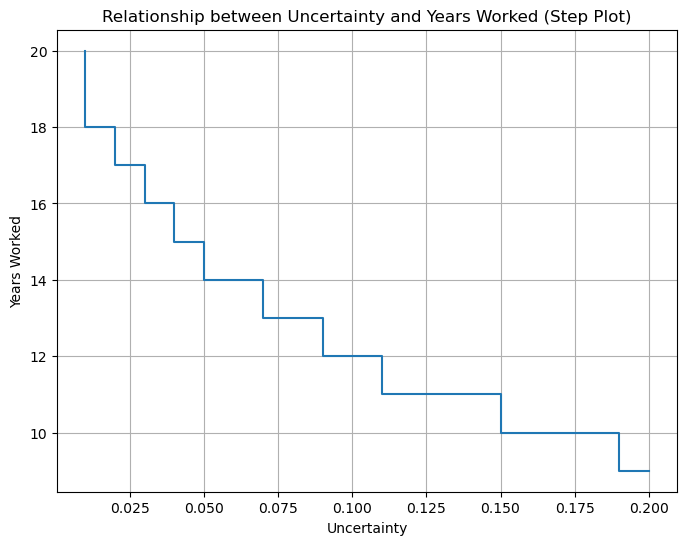

In [36]:
# Generate the full graph for all uncertainty levels
certainty_levels = np.linspace(0.80, 0.99, 20)  # Certainty levels: 80% to 99%
uncertainty_levels = 1 - certainty_levels  # Uncertainty levels: 20% to 1%
years_worked = []  # Store years worked for each uncertainty level

retirement_ages = range(starting_age, max_age + 1)

for certainty in certainty_levels:
    found = False  # Flag to track if a value was found
    for retirement_age in retirement_ages:
        success_rate = monte_carlo_simulation(retirement_age)
        if success_rate >= certainty:  # Meets the certainty level
            years_worked.append(retirement_age - starting_age)  # Calculate years worked
            found = True
            break
    if not found:
        years_worked.append(None)  # Add None if no valid retirement age was found

# Plot the relationship between uncertainty and years worked
plt.figure(figsize=(8, 6))
plt.step(uncertainty_levels, years_worked, where='post')
plt.xlabel('Uncertainty')
plt.ylabel('Years Worked')
plt.title('Relationship between Uncertainty and Years Worked (Step Plot)')
plt.grid()
plt.show()

## **8. Conclusions**

First Conclusion

The relative would need to work an additional 15 years to ensure that the probability of running out of money remains below 5%. Considering the level of uncertainty he wishes to account for, he can be classified as risk-averse. In contrast, a risk-neutral individual would likely require fewer years to save enough, as they would rely on ETF interest exceeding their annual withdrawals sooner. Additionally, if market performance is exceptionally strong in the early years of the simulation, it may indicate a higher likelihood of earlier retirement, demonstrating how the model adapts dynamically to financial conditions.

If he wishes to retire sooner due to dissatisfaction with his current job, there are several alternatives to consider. For example, he could increase annual savings invested in ETFs by reducing current consumption, lower his future withdrawal amounts to account for higher uncertainty, choose riskier investments with potentially higher returns to achieve his goal faster, or relocate to a more affordable area to reduce living expenses, among other strategies.

It is important to note that the model has certain limitations in real-world applications. Past returns cannot reliably predict future performance, as many factors, such as domestic and international political developments, wars, climate change, global disasters like COVID-19, and technological advancements can significantly impact returns in the years ahead.

Second Conclusion

This model enhances unpredictability by assigning random ages in each simulation and continuously comparing new random numbers against age-specific death probabilities. This dynamic process avoids fixed age assignments at the start of the simulation, allowing for greater variability throughout. Taking into account the law of large numbers—which states that as the number of trials increases, the sample mean converges to the expected value—this approach provides a reasonable approximation of real-world averages, offering insights for retirement planning, though it does not fully replicate reality.

As no specific information was available regarding the health condition of the relative, the simulation assumes the characteristics of an average man at age 55, even though the relative’s actual life expectancy could be better or worse depending on individual health factors. 

Third Conclusion

A deterministic approach was initially attempted, where fixed death ages were assigned proportionally across simulations, resulting in a more rigid and conservative estimate of 24 years for 5% uncertainty. However, this method assumes outcomes that may not fully reflect real-life variability. The method used in our final model dynamically assigns death ages based on random outcomes, capturing life’s unpredictability more effectively. This leads to a shorter estimate of 15 years for 5% uncertainty, accounting for realistic variations in lifespan and financial conditions, and providing a less conservative yet more adaptable result.